### Notebook Summary

In this notebook, we grouped the entries into binary classes (1: similar, 0: dissimilar) to analyse whether our model's performance improve once the compleixty of multi-group is removed.

# Binary Classification with Keras

https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

Data Preparation

In [2]:
# Import data
train_df = pd.read_csv('train/_TRAIN_features_complete_df.csv')
test_df = pd.read_csv('eval/_EVAL_features_complete_df.csv')
all_df = pd.concat([train_df,test_df])

In [3]:
# Change 'overall' to 0,1
# 0 being not similar and 1 being similar

# Train data
for idx,row in train_df.iterrows():
    overall = row['overall']
    if overall <=2:
        train_df.at[idx,'overall'] = 1
    else:
        train_df.at[idx,'overall'] = 0

# Test Data
for idx,row in test_df.iterrows():
    overall = row['overall']
    if overall <=2:
        test_df.at[idx,'overall'] = 1
    else:
        test_df.at[idx,'overall'] = 0

In [4]:
# Check training data labels
print('Check training data label imbalance:')
print(train_df.groupby('overall').size(),'\n')

Check training data label imbalance:
overall
0    1559
1    1026
dtype: int64 



# Training with Imbalanced Data

In [5]:
# Imbalanced training data
target_column = ['overall']
predictors = list(set(list(train_df.drop(['pair_id'], axis=1).columns))-set(target_column))

X_train = train_df[predictors].values
y_train = train_df[target_column].values
X_test = test_df[predictors].values
y_test = test_df[target_column].values

X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [6]:
# Imbalanced training data shape : 2585
# Balanced training data shape : 2052

print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(2585, 5)
(2773, 5)
(2585, 1)
(2773, 1)


Create KerasClassifier

In [8]:
# Initialize model with random hyperparameter
hidden_size = 8
epoch = 100
input_size = X_train.shape[1]
learning_rate = 0.01
batch_size = 5
kfold = 5

def baseline_model():
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    #model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Create a KerasClassfier
estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)

# Number of folds
kfold = KFold(n_splits=kfold, shuffle=True)

C:\Users\Rinrada\AppData\Local\Temp/ipykernel_3908/1808950710.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)


Cross Validation in Training Data

In [9]:
start = time.time()
results_binn = cross_val_score(estimator, X_train, y_train, cv=kfold)

print('Time(s) used:',time.time() - start)
print("Baseline: %.2f%% (%.2f%%)" % (results_binn.mean()*100, results_binn.std()*100))

Time(s) used: 282.2414593696594
Baseline: 81.74% (1.80%)


Evaluation with test data

In [10]:
# Fit train data
train_result = estimator.fit(X_train, y_train, verbose=1)

Epoch 1/100
517/517 [==============================] - 1s 1ms/step - loss: 0.4828 - accuracy: 0.7799
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.4102 - accuracy: 0.8116
Epoch 3/100
517/517 [==============================] - 1s 1ms/step - loss: 0.4089 - accuracy: 0.8174
Epoch 4/100
517/517 [==============================] - 1s 1ms/step - loss: 0.4023 - accuracy: 0.8132
Epoch 5/100
517/517 [==============================] - 1s 2ms/step - loss: 0.4034 - accuracy: 0.8143
Epoch 6/100
517/517 [==============================] - 1s 1ms/step - loss: 0.4016 - accuracy: 0.8143
Epoch 7/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3976 - accuracy: 0.8174
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.3987 - accuracy: 0.8182
Epoch 9/100
517/517 [==============================] - 1s 1ms/step - loss: 0.3969 - accuracy: 0.8205
Epoch 10/100
517/517 [==============================] - 1s 1ms/step - loss: 0.3957 - accura

In [11]:
# Make prediction and get accuracy
y_pred = estimator.predict(X_test)
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_pred = np_utils.to_categorical(y_pred)
print('Accuracy on test data:',accuracy_score(dummy_y_test, dummy_y_pred)*100,'%')

Accuracy on test data: 77.46123332131266 %


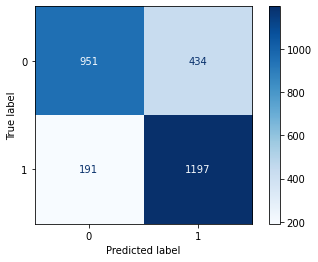

In [12]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [13]:
print(classification_report(dummy_y_test, dummy_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1385
           1       0.73      0.86      0.79      1388

   micro avg       0.77      0.77      0.77      2773
   macro avg       0.78      0.77      0.77      2773
weighted avg       0.78      0.77      0.77      2773
 samples avg       0.77      0.77      0.77      2773



### Our Observation

Using the same random set of hyperparmeters, our prediction drastically improved. Interesting, while the imbalanced training set fed in about 50% more entries labeled as 0 than 1, the model still predicts more entries as 'similar'.

Then we performed GridSearch to find optimal hyperparameters:
- activation function
- optimizer
- batch size
- number of epochs
- learning rate
- neurons

In [41]:
def create_model_grid(neurons = 5 , activation = 'relu', learning_rate = '0.001', optimizer='adam',):
    # Create model
    model = Sequential()
    
    # Activation functions
    if activation=='relu':
        model.add(Dense(neurons, input_dim=input_size, activation='relu'))
        #model.add(Dense(neurons, activation='relu'))
    if activation=='tanh':
        model.add(Dense(neurons, input_dim=input_size, activation='tanh'))
        #model.add(Dense(neurons, activation='tanh'))
    if activation=='sigmoid':
        model.add(Dense(neurons, input_dim=input_size, activation='sigmoid'))
        #model.add(Dense(neurons, activation='sigmoid'))
        
    # Output layer    
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizers
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

In [ ]:
estimator_grid = KerasClassifier(build_fn=create_model_grid, verbose=0)

In [43]:
# List of hyperparameters to be searched
activation_list = ['tanh','relu']
optimizer_list = ['rmsprop','adam','sgd']
epoch_list = [5,10,20]
batch_list = [10,20,50]
learning_rate_list = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons_list = [8, 32, 64]

In [44]:
# Set up GridSearch
param_grid = dict(activation = activation_list,
                 optimizer = optimizer_list,
                 epochs = epoch_list, 
                  batch_size = batch_list,
                 learning_rate = learning_rate_list,
                 neurons = neurons_list)

# Search with 3 folds (cross_validation)
grid = GridSearchCV(estimator = estimator_grid, param_grid = param_grid, cv=3, verbose=2)

In [45]:
# Training to get the best hyperparameter combination
grid_result = grid.fit(X_train,y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; tota

[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.5s
[CV] END activation=tanh, batch_size=10, epochs=5, learnin

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   3.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.3s
[CV] END activation=tanh, batch_size=10

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   3.5s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   4.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   3.9s
[CV] END activation=tanh, batch_size=10, epochs=10, l

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   7.7s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=  13.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   8.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   9.5s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   8.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   9.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   7.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   7.8s
[CV] END activation=tanh, batch_si

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=  10.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   8.7s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   8.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   8.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   8.8s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   8.2s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   6.2s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=adam; total time=   7.1s
[CV] END activation=tanh, batch_size=10, epochs=20, le

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   1.7s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epoc

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2,

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   3.8s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   3.8s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   4.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   4.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   3.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   4.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_s

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=adam; total time=   3.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   4.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   4.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   4.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   4.9s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   3.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   3.7s
[CV] END activation=tanh, batch_size=20, epochs=10, le

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   4.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   4.3s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   4.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   5.1s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   4.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   4.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   3.8s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   4.9s
[CV] END activation=tanh, batch_size=20

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   4.5s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   4.6s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   3.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   4.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   4.5s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=20

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=5,

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_r

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   2.5s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=50, epochs=10, l

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   3.1s
[CV] END activation=tanh, batch_size=50, epochs=1

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=adam; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.8s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.9s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=50, epoch

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.5s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.4s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   3.6s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   3.7s
[CV] END activation=tanh, batch_size=50, epochs=20, lea

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.1s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.7s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=relu, batch_size=10, epochs=5, le

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   3.0s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   3.7s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   3.8s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   4.1s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.1s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.0s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   3.7s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=adam; total time=   4.8s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   4.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   4.4s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   4.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   4.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   5.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   4.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=adam; total time=   4.3s
[CV] END activation=relu, batch_size=10, e

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   7.4s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   6.1s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   5.1s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   4.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   5.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   5.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   5.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   5.4s
[CV] END activation=relu, batch_size=10, epochs=10, learnin

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   8.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   9.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   7.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   9.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   8.7s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   8.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   7.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   8.1s
[CV] END activation=relu, batch_size=10, 

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   7.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   7.6s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   7.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   8.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   8.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   8.1s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   7.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   7.1s
[CV] END activation=relu, batch_size=10, epochs=20,

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   2.4s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   3.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=5, learn

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.4s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_r

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   3.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.6s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.6s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=10, lea

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   3.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=10

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   4.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   4.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   5.2s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   4.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   3.5s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   3.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   4.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   3.8s
[CV] END activation=relu, batch_size=20, epochs=20, learnin

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   4.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   8.5s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   3.5s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   3.4s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   3.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   3.5s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=50, epochs=5, le

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=5, learnin

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=

[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.4s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.4s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, l

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.0s
[CV] END activation=relu, batch_size=50, epoc

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.4s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=2

In [46]:
# Print Best Result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.820506 using {'activation': 'tanh', 'batch_size': 50, 'epochs': 10, 'learning_rate': 0.01, 'neurons': 8, 'optimizer': 'rmsprop'}


In [47]:
# Get Hyperparameter listed out and shown as dataframe
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['Mean'] = means
df['Std'] = stds

df.sort_values('Mean',ascending=False)

,activation,batch_size,epochs,learning_rate,neurons,optimizer,Mean,Std
324,tanh,50,10,0.010,8,rmsprop,0.820506,0.009426
498,relu,10,20,0.001,32,rmsprop,0.819344,0.009306
777,relu,50,20,0.010,32,rmsprop,0.819344,0.007861
463,relu,10,10,0.010,32,adam,0.818958,0.008201
507,relu,10,20,0.010,32,rmsprop,0.818958,0.010722
...,...,...,...,...,...,...,...,...
722,relu,50,10,0.001,8,sgd,0.566297,0.089752
137,tanh,20,5,0.001,8,sgd,0.516863,0.066653
272,tanh,50,5,0.001,8,sgd,0.501376,0.107826
165,tanh,20,5,0.200,32,rmsprop,0.499116,0.151685


In [48]:
# Details in the traininf results
grid_result.cv_results_

{'mean_fit_time': array([ 2.02987536,  1.77260081,  1.83775012,  2.04248365,  2.00700172,
         1.76328198,  1.98455199,  2.01479133,  1.78641582,  2.14215493,
         1.82497915,  1.76237408,  2.02340388,  1.91969895,  1.84401647,
         1.8851556 ,  2.05809132,  1.82971096,  2.02842053,  2.00458066,
         1.84334707,  2.11517954,  2.04562442,  2.133919  ,  2.02110807,
         2.10539118,  2.08594076,  1.99009999,  2.00940331,  1.71993001,
         2.21022153,  1.81339661,  1.85619362,  1.99541457,  2.32609208,
         1.87949649,  2.29888272,  2.31762067,  1.8645618 ,  2.57610369,
         1.85129094,  1.92439286,  1.9201502 ,  2.25975593,  1.6529115 ,
         3.09207257,  2.91019026,  2.78992875,  3.03313351,  2.79749894,
         3.1070083 ,  3.15766191,  3.20313025,  2.92031844,  3.29665208,
         3.20929623,  3.46138374,  4.65441076,  3.05566239,  3.74198079,
         3.90794611,  3.77466448,  3.18459153,  3.43069132,  3.91263755,
         2.99034452,  3.51631999, 

In [49]:
# Make prediction on test data with the best hyperparameters
y_pred = grid.predict(X_test)

print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 80.02163721601154 %
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1385
           1       0.81      0.79      0.80      1388

    accuracy                           0.80      2773
   macro avg       0.80      0.80      0.80      2773
weighted avg       0.80      0.80      0.80      2773



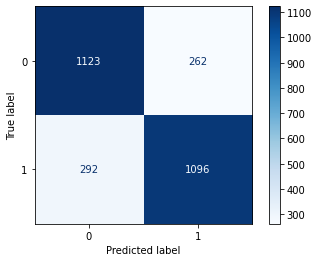

In [50]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [75]:
df.to_csv('model/NN_biclass-gridsearch-imbalanced.csv')

Interestingly, with the optimised hyperparmaters, the model predicted roughly the same amount of entries as dissimilar and similar, even on imbalanced data. Showing that the tendency to predict entries as 1 as we've seen in with the randomly selected hyperparamters might not be reproducible with other hyperparmeter combinations. With that in mind, we are still repeating the same process with balanced data to see if there's any noticable difference.

# Training with Balanced Data

Data Set-up

In [14]:
# Balanced data
balancing = train_df.groupby('overall')
balance_train_df = balancing.apply(lambda x: x.sample(balancing.size().min()))
balance_train_df = balance_train_df.reset_index(drop=True)
print('Check training data label balance:')
print(balance_train_df.groupby('overall').size(),'\n')

Check training data label balance:
overall
0    1026
1    1026
dtype: int64 



In [15]:
# Balanced training data
target_column = ['overall']
predictors = list(set(list(balance_train_df.drop(['pair_id'], axis=1).columns))-set(target_column))

X_train = balance_train_df[predictors].values
y_train = balance_train_df[target_column].values
#X_test = balance_train_df[predictors].values
#y_test = balance_train_df[target_column].values

X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [16]:
# Imbalanced training data shape : 2585
# Balanced training data shape : 2052

print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(2052, 5)
(2773, 5)
(2052, 1)
(2773, 1)


Create KerasClassifier

In [18]:
# Initialize model with random hyperparameter
hidden_size = 8
epoch = 100
input_size = X_train.shape[1]
learning_rate = 0.01
batch_size = 5
kfold = 5

def baseline_model():
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    #model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Create a KerasClassfier
estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)

# Number of folds
kfold = KFold(n_splits=kfold, shuffle=True)

C:\Users\Rinrada\AppData\Local\Temp/ipykernel_3908/1808950710.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)


Cross Validation in Training Data

In [19]:
start = time.time()
results_binn = cross_val_score(estimator, X_train, y_train, cv=kfold)

print('Time(s) used:',time.time() - start)
print("Baseline: %.2f%% (%.2f%%)" % (results_binn.mean()*100, results_binn.std()*100))

Time(s) used: 193.39749598503113
Baseline: 81.77% (1.77%)


Evaluate with Test Data

In [20]:
# Fit train data
train_result = estimator.fit(X_train, y_train, verbose=1)

Epoch 1/100
411/411 [==============================] - 1s 1ms/step - loss: 0.5160 - accuracy: 0.7485
Epoch 2/100
411/411 [==============================] - 1s 1ms/step - loss: 0.4125 - accuracy: 0.8163
Epoch 3/100
411/411 [==============================] - 1s 2ms/step - loss: 0.4068 - accuracy: 0.8212
Epoch 4/100
411/411 [==============================] - 1s 2ms/step - loss: 0.4051 - accuracy: 0.8192
Epoch 5/100
411/411 [==============================] - 0s 1ms/step - loss: 0.4017 - accuracy: 0.8192
Epoch 6/100
411/411 [==============================] - 1s 1ms/step - loss: 0.4044 - accuracy: 0.8207
Epoch 7/100
411/411 [==============================] - 1s 1ms/step - loss: 0.4031 - accuracy: 0.8138
Epoch 8/100
411/411 [==============================] - 0s 1ms/step - loss: 0.3998 - accuracy: 0.8221
Epoch 9/100
411/411 [==============================] - 0s 1ms/step - loss: 0.3994 - accuracy: 0.8197
Epoch 10/100
411/411 [==============================] - 0s 1ms/step - loss: 0.4006 - accura

In [21]:
# Make prediction and get accuracy
y_pred = estimator.predict(X_test)
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_pred = np_utils.to_categorical(y_pred)
print('Accuracy on test data:',accuracy_score(dummy_y_test, dummy_y_pred)*100,'%')

Accuracy on test data: 76.92030292102416 %


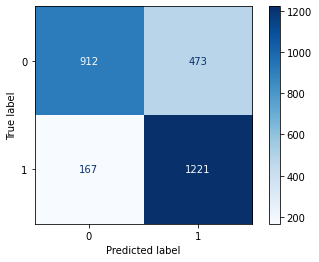

In [22]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [23]:
print(classification_report(dummy_y_test, dummy_y_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1385
           1       0.72      0.88      0.79      1388

   micro avg       0.77      0.77      0.77      2773
   macro avg       0.78      0.77      0.77      2773
weighted avg       0.78      0.77      0.77      2773
 samples avg       0.77      0.77      0.77      2773



GridSearch for Optimal Hyperparameters

In [60]:
def create_model_grid(neurons = 5 , activation = 'relu', learning_rate = '0.001', optimizer='adam',):
    # Create model
    model = Sequential()
    
    # Activation functions
    if activation=='relu':
        model.add(Dense(neurons, input_dim=input_size, activation='relu'))
        #model.add(Dense(neurons, activation='relu'))
    if activation=='tanh':
        model.add(Dense(neurons, input_dim=input_size, activation='tanh'))
        #model.add(Dense(neurons, activation='tanh'))
    if activation=='sigmoid':
        model.add(Dense(neurons, input_dim=input_size, activation='sigmoid'))
        #model.add(Dense(neurons, activation='sigmoid'))
        
    # Output layer    
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizers
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

In [61]:
estimator_grid = KerasClassifier(build_fn=create_model_grid, verbose=0)

C:\Users\Rinrada\AppData\Local\Temp/ipykernel_12916/685262876.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_grid = KerasClassifier(build_fn=create_model_grid, verbose=0)


In [62]:
# List of hyperparameters to be searched
activation_list = ['tanh','relu']
optimizer_list = ['rmsprop','adam','sgd']
epoch_list = [5,10,20]
batch_list = [10,20,50]
learning_rate_list = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons_list = [8, 32, 64]

In [63]:
# Set up GridSearch
param_grid = dict(activation = activation_list,
                 optimizer = optimizer_list,
                 epochs = epoch_list, 
                  batch_size = batch_list,
                 learning_rate = learning_rate_list,
                 neurons = neurons_list)

# Search with 3 folds (cross_validation)
grid = GridSearchCV(estimator = estimator_grid, param_grid = param_grid, cv=3, verbose=2)

In [64]:
# Training to get the best hyperparameter combination
grid_result = grid.fit(X_train,y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.5s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.8s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; tota

[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.4s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learnin

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   4.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   4.3s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   4.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   4.5s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   4.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.2s
[CV] END activation=tanh, batch_size=10

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   3.7s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   5.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   3.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   3.6s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   2.7s
[CV] END activation=tanh, batch_size=10, epochs=10, l

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   4.7s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   4.6s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   5.0s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   4.5s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   4.6s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   4.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   4.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   4.2s
[CV] END activation=tanh, batch_si

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   4.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   4.5s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   5.0s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=64, optimizer=sgd; total time=   4.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   6.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   5.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   6.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=adam; total time=  16.0s
[CV] END activation=tanh, batch_size=10, epochs=20, le

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=20, epoc

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2,

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   2.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=adam; total time=   2.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   2.4s
[CV] END activation=tanh, batch_s

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.8s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=10, le

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=rmsprop; total time=   3.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   3.3s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=adam; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   4.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   3.5s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   4.3s
[CV] END activation=tanh, batch_size=20

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   3.7s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   3.2s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   3.6s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   3.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   4.1s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   3.1s
[CV] END activation=tanh, batch_size=20, epochs=20

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=64, optimizer=sgd; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=5,

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   5.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_r

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   2.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=50, epochs=10, l

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=rmsprop; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   1.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   3.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=adam; total time=   3.5s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=1

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=adam; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.8s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.8s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epoch

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.5s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   2.3s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=50, epochs=20, lea

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.0s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.7s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=10, epochs=5, le

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.2, neurons=64, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.8s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.1s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   2.7s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   2.8s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=64, optimizer=adam; total time=   3.0s
[CV] END activation=relu, batch_size=10, e

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   3.5s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   4.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   4.4s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=10, epochs=10, learnin

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   5.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   4.7s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=rmsprop; total time=   5.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   5.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   4.8s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=adam; total time=   5.1s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   4.8s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   4.9s
[CV] END activation=relu, batch_size=10, 

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   4.8s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   4.4s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   4.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   4.8s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   4.6s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   4.7s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   5.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   4.9s
[CV] END activation=relu, batch_size=10, epochs=20,

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   1.5s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   1.5s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=5, learn

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   1.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_r

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.01, neurons=64, optimizer=sgd; total time=   3.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   3.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   2.8s
[CV] END activation=relu, batch_size=20, epochs=10, lea

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   3.0s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=10

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   4.7s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   3.4s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   3.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   3.3s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   3.4s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   3.4s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   3.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   4.2s
[CV] END activation=relu, batch_size=20, epochs=20, learnin

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   3.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=rmsprop; total time=   3.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=adam; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   2.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=50, epochs=5, le

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=5, learnin

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=64, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=

[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.5s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=10, l

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.4s
[CV] END activation=relu, batch_size=50, epoc

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.4s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.4s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=64, optimizer=adam; total time=   1.8s
[CV] END activation=relu, batch_size=50, epochs=2

In [65]:
# Print Best Result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.824561 using {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'learning_rate': 0.01, 'neurons': 32, 'optimizer': 'adam'}


In [66]:
# Get Hyperparameter listed out and shown as dataframe
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['Mean'] = means
df['Std'] = stds

df.sort_values('Mean',ascending=False)

,activation,batch_size,epochs,learning_rate,neurons,optimizer,Mean,Std
643,relu,20,20,0.010,32,adam,0.824561,0.008608
598,relu,20,10,0.010,32,adam,0.822612,0.008469
128,tanh,10,20,0.300,8,sgd,0.822125,0.009649
511,relu,10,20,0.010,64,adam,0.822125,0.007294
507,relu,10,20,0.010,32,rmsprop,0.822125,0.006126
...,...,...,...,...,...,...,...,...
140,tanh,20,5,0.001,32,sgd,0.452729,0.039955
548,relu,20,5,0.001,64,sgd,0.430799,0.025219
362,tanh,50,20,0.001,8,sgd,0.413255,0.056702
365,tanh,50,20,0.001,32,sgd,0.391813,0.090981


In [73]:
# Details in the traininf results
grid_result.cv_results_

{'mean_fit_time': array([2.20488874e+00, 2.15313943e+00, 1.91519825e+00, 2.16574184e+00,
        1.81061268e+00, 1.83774201e+00, 2.23642063e+00, 2.31316574e+00,
        1.99478165e+00, 2.37340283e+00, 2.16502794e+00, 2.05105042e+00,
        2.30550114e+00, 2.14559460e+00, 2.02141062e+00, 2.09948746e+00,
        1.82924263e+00, 1.92664417e+00, 2.10251458e+00, 1.95074256e+00,
        1.81745474e+00, 2.02912815e+00, 2.12707535e+00, 2.04592021e+00,
        2.26646996e+00, 1.82255801e+00, 1.96900296e+00, 1.93671195e+00,
        1.95158474e+00, 1.75161282e+00, 2.00580454e+00, 1.97519883e+00,
        1.85636878e+00, 2.11757127e+00, 1.90654985e+00, 1.72178944e+00,
        1.97099320e+00, 1.87283349e+00, 1.82630165e+00, 2.08797177e+00,
        1.98462590e+00, 1.85995690e+00, 1.98989979e+00, 2.01007811e+00,
        1.69973858e+00, 7.07548078e+00, 3.61445697e+00, 3.72848185e+00,
        3.50127570e+00, 3.12185494e+00, 2.55969000e+00, 3.01928242e+00,
        3.42782760e+00, 2.78993964e+00, 3.57898

In [67]:
# Make prediction on test data with the best hyperparameters
y_pred = grid.predict(X_test)

print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 82.89473684210526 %
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1026
           1       0.85      0.80      0.82      1026

    accuracy                           0.83      2052
   macro avg       0.83      0.83      0.83      2052
weighted avg       0.83      0.83      0.83      2052



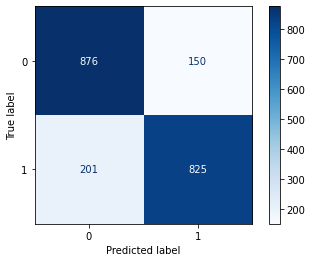

In [68]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

In [76]:
df.to_csv('model/NN_biclass-gridsearch-balanced.csv')

### Our observation

Compared to performing binary classification on imbalanced data, while there was no noticable tendency for the imbalancedly fitted model to predict more test set entries as group 0, we did see an improvement on performance metrics like accuracy (80 to 82%), precision, and recall when fitted with balanced data.